# 05-2025/01/13 RAPIDS Project Handover Summary

In [1]:
# 07_certificate_lifecycle_analysis.ipynb
# Location: RAPIDS/notebooks/certificate_analysis/07_certificate_lifecycle_analysis.ipynb

"""
Certificate Lifecycle Analysis Notebook
This notebook analyzes:
- Certificate validity periods
- Renewal patterns
- Weekday vs weekend issuance patterns
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from sqlalchemy import create_engine
import json
from pathlib import Path
import logging
from datetime import datetime, timedelta
import re
from typing import Dict, Tuple
from IPython.display import display

# Setup configurations
CONFIG_PATH = '/home/asomura/waseda/nextstep/RAPIDS/config/database.json'
BASE_DIR = Path('/home/asomura/waseda/nextstep/RAPIDS')
OUTPUT_DIR = BASE_DIR / 'reports' / 'lifecycle_analysis'
LOG_DIR = BASE_DIR / 'data' / 'logs'

# Create necessary directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

# Setup logging
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
logging.basicConfig(
    filename=LOG_DIR / f'lifecycle_analysis_{timestamp}.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Load database configuration
with open(CONFIG_PATH) as f:
    config = json.load(f)['database']

In [2]:
def get_database_engine(db_name: str) -> create_engine:
    """Create database connection engine"""
    host = '192.168.1.92' if db_name == 'website_data' else '192.168.1.92'
    return create_engine(
        f"postgresql://{config['user']}:{config['password']}@{host}/{db_name}"
    )

In [3]:
def extract_certificate_data(db_name: str) -> pd.DataFrame:
    """Extract certificate data from database"""
    query = """
    SELECT 
        domain,
        https_certificate_issuer,
        https_certificate_expiry,
        last_update,
        domain_registrar,
        https_certificate_domain,
        https_certificate_body,
        https_certificate_public_key,
        https_certificate_signature_algorithm
    FROM website_data 
    WHERE status = 7 
    AND https_certificate_issuer IS NOT NULL
    AND last_update IS NOT NULL
    ORDER BY last_update
    """
    
    engine = get_database_engine(db_name)
    df = pd.read_sql_query(query, engine)
    df['last_update'] = pd.to_datetime(df['last_update'])
    return df

In [4]:
def extract_validity_period(expiry_text: str) -> int:
    """
    Extract validity period from certificate expiry date
    Format: YYYYMMDDHHmmssZ (e.g., 20241028073105Z)
    
    Args:
        expiry_text: Certificate expiry date in Generalized Time format
        
    Returns:
        Number of days until expiry from issuance
    """
    if pd.isna(expiry_text):
        return 0
        
    try:
        # Parse expiry date
        expiry_date = datetime.strptime(expiry_text, '%Y%m%d%H%M%SZ')
        
        # Calculate days from now to expiry
        days_until_expiry = (expiry_date - datetime.now()).days
        return max(days_until_expiry, 0)  # Ensure non-negative
        
    except Exception as e:
        logger.warning(f"Error parsing expiry date: {str(e)}")
        return 0


In [5]:
def analyze_validity_periods(df: pd.DataFrame) -> dict:
    """Analyze certificate validity periods"""
    validity_periods = df['https_certificate_expiry'].apply(extract_validity_period)
    
    # Calculate statistics
    stats = {
        'mean': validity_periods.mean(),
        'median': validity_periods.median(),
        'std': validity_periods.std(),
        'min': validity_periods.min(),
        'max': validity_periods.max()
    }
    
    # Categorize based on remaining validity
    categories = {
        'short_term': (validity_periods <= 90).mean(),  # 90 days or less
        'medium_term': ((validity_periods > 90) & (validity_periods <= 365)).mean(),
        'long_term': (validity_periods > 365).mean()
    }
    
    # Create distribution with meaningful bins
    bins = [0, 30, 60, 90, 180, 365, float('inf')]
    labels = ['1-30 days', '31-60 days', '61-90 days', '91-180 days', '181-365 days', '365+ days']
    binned = pd.cut(validity_periods, bins=bins, labels=labels)
    distribution = binned.value_counts().to_dict()
    
    return {
        'statistics': stats,
        'categories': categories,
        'distribution': distribution
    }


In [6]:
def analyze_renewal_patterns(df: pd.DataFrame) -> dict:
    """Analyze certificate renewal patterns"""
    df = df.sort_values(['domain', 'last_update'])
    intervals = df.groupby('domain')['last_update'].diff().dt.total_seconds() / 86400
    
    return {
        'statistics': {
            'mean_interval': intervals.mean(),
            'median_interval': intervals.median(),
            'std_interval': intervals.std()
        },
        'renewal_counts': df.groupby('domain').size().value_counts().to_dict(),
        'interval_distribution': intervals.value_counts().sort_index().to_dict()
    }

In [7]:
def analyze_temporal_patterns(df: pd.DataFrame) -> dict:
    """Analyze temporal patterns in certificate issuance"""
    df['weekday'] = df['last_update'].dt.dayofweek
    df['hour'] = df['last_update'].dt.hour
    df['is_weekend'] = df['weekday'].isin([5, 6])
    df['is_business_hours'] = df['hour'].between(9, 17)
    
    return {
        'weekday_distribution': df['weekday'].map(lambda x: calendar.day_name[x])
            .value_counts().to_dict(),
        'hour_distribution': df['hour'].value_counts().sort_index().to_dict(),
        'patterns': {
            'weekend_ratio': df['is_weekend'].mean(),
            'business_hours_ratio': df['is_business_hours'].mean(),
            'weekend_business_hours_ratio': df[df['is_weekend']]['is_business_hours'].mean()
        }
    }

In [8]:
def analyze_renewal_patterns(df: pd.DataFrame) -> Dict:
    """
    Analyze certificate renewal patterns with extensive debugging
    
    Args:
        df: DataFrame containing certificate data
        
    Returns:
        Dictionary containing renewal analysis results
    """
    # Check for duplicate domains
    domain_counts = df['domain'].value_counts()
    domains_with_multiples = domain_counts[domain_counts > 1]
    
    print("\nInitial Data Analysis:")
    print(f"Total records: {len(df)}")
    print(f"Unique domains: {len(domain_counts)}")
    print(f"Domains with multiple certificates: {len(domains_with_multiples)}")
    
    if len(domains_with_multiples) > 0:
        print("\nTop 5 domains with multiple certificates:")
        print(domains_with_multiples.head())
        
        # Detailed analysis of first domain with multiple certificates
        example_domain = domains_with_multiples.index[0]
        example_certs = df[df['domain'] == example_domain].sort_values('last_update')
        
        print(f"\nDetailed analysis for domain: {example_domain}")
        print("Certificate timeline:")
        for idx, row in example_certs.iterrows():
            print(f"  {row['last_update']}")
    
    # Sort by domain and date
    df_sorted = df.sort_values(['domain', 'last_update'])
    
    renewal_info = {
        'intervals': [],
        'renewal_counts': {},
        'domains_with_renewals': set()
    }
    
    # Process each domain
    for domain, group in df_sorted.groupby('domain'):
        if len(group) > 1:
            # Get sorted dates
            dates = group['last_update'].tolist()
            
            # Calculate intervals
            intervals = []
            for i in range(len(dates)-1):
                interval = (dates[i+1] - dates[i]).total_seconds() / 86400
                if interval > 0:
                    intervals.append(interval)
            
            if intervals:
                renewal_info['intervals'].extend(intervals)
                renewal_info['renewal_counts'][domain] = len(intervals) + 1
                renewal_info['domains_with_renewals'].add(domain)
    
    # Calculate statistics
    if renewal_info['intervals']:
        interval_series = pd.Series(renewal_info['intervals'])
        stats = {
            'mean_interval': interval_series.mean(),
            'median_interval': interval_series.median(),
            'std_interval': interval_series.std(),
            'min_interval': interval_series.min(),
            'max_interval': interval_series.max(),
            'total_renewals': sum(renewal_info['renewal_counts'].values()),
            'unique_domains': len(renewal_info['domains_with_renewals'])
        }
    else:
        stats = {
            'mean_interval': 0,
            'median_interval': 0,
            'std_interval': 0,
            'min_interval': 0,
            'max_interval': 0,
            'total_renewals': 0,
            'unique_domains': 0
        }
    
    return {
        'statistics': stats,
        'renewal_counts': renewal_info['renewal_counts'],
        'interval_distribution': pd.Series(renewal_info['intervals']).describe().to_dict() if renewal_info['intervals'] else {},
        'renewal_frequency': pd.Series(renewal_info['renewal_counts']).value_counts().to_dict() if renewal_info['renewal_counts'] else {}
    }

def print_renewal_summary(results: Dict) -> None:
    """Print detailed renewal analysis summary"""
    stats = results['statistics']
    
    print("\nRenewal Pattern Analysis Summary:")
    if stats['total_renewals'] > 0:
        print(f"Total renewals: {stats['total_renewals']}")
        print(f"Unique domains with renewals: {stats['unique_domains']}")
        print(f"Mean renewal interval: {stats['mean_interval']:.2f} days")
        print(f"Median renewal interval: {stats['median_interval']:.2f} days")
        print(f"Min renewal interval: {stats['min_interval']:.2f} days")
        print(f"Max renewal interval: {stats['max_interval']:.2f} days")
        
        if results['renewal_frequency']:
            print("\nRenewal frequency distribution:")
            for renewals, count in sorted(results['renewal_frequency'].items()):
                print(f"{renewals} renewals: {count} domains")
    else:
        print("No renewal patterns detected in the data")

In [9]:
def plot_renewal_patterns(results: dict, db_name: str):
    """
    Plot certificate renewal patterns analysis
    
    Args:
        results: Dictionary containing renewal analysis results
        db_name: Name of the database analyzed
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Renewal Intervals Distribution
    if results['intervals']:
        # Create histogram of renewal intervals
        intervals = pd.Series(results['intervals'])
        ax1.hist(intervals, bins=30, color='#2196F3', edgecolor='black')
        ax1.set_title('Certificate Renewal Interval Distribution')
        ax1.set_xlabel('Days between Renewals')
        ax1.set_ylabel('Frequency')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No renewal data available', 
                ha='center', va='center')
    
    # Plot 2: Renewal Counts per Domain
    if results['renewal_counts']:
        counts = list(results['renewal_counts'].keys())
        frequencies = list(results['renewal_counts'].values())
        
        ax2.bar(counts, frequencies, color='#4CAF50')
        ax2.set_title('Number of Renewals per Domain')
        ax2.set_xlabel('Number of Renewals')
        ax2.set_ylabel('Number of Domains')
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on top of bars
        for i, v in enumerate(frequencies):
            ax2.text(counts[i], v, str(v), 
                    ha='center', va='bottom')
    else:
        ax2.text(0.5, 0.5, 'No renewal count data available', 
                ha='center', va='center')
    
    plt.suptitle(f'Certificate Renewal Patterns - {db_name}', y=1.02)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(OUTPUT_DIR / f'renewal_patterns_{db_name}_{timestamp}.png', 
                bbox_inches='tight', dpi=300)
    plt.close()

In [10]:


def plot_temporal_patterns(results: Dict, db_name: str, output_dir: Path) -> Tuple[plt.Figure, str]:
    """
    Plot temporal patterns and display in Jupyter notebook
    
    Args:
        results: Dictionary containing temporal analysis results
        db_name: Name of the database analyzed
        output_dir: Directory to save the output files
        
    Returns:
        Tuple of (Figure object, Path to saved file)
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Weekday distribution
    weekday_dist = results['weekday_distribution']
    days = list(calendar.day_name)
    counts = [weekday_dist.get(day, 0) for day in days]
    
    ax1.bar(range(len(days)), counts)
    ax1.set_title('Certificate Issuance by Day of Week')
    ax1.set_xticks(range(len(days)))
    ax1.set_xticklabels(days, rotation=45)
    
    # Hour distribution
    hour_dist = results['hour_distribution']
    hours = range(24)
    counts = [hour_dist.get(hour, 0) for hour in hours]
    
    ax2.plot(hours, counts, marker='o')
    ax2.set_title('Certificate Issuance by Hour')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Number of Certificates')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(hours)
    
    plt.suptitle(f'Temporal Patterns Analysis - {db_name}', y=1.02)
    plt.tight_layout()
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save the figure
    output_path = output_dir / f'temporal_patterns_{db_name}_{timestamp}.png'
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    
    # Display the plot in Jupyter
    display(plt.gcf())
    
    # Close the figure to free memory
    plt.close()
    
    return output_path

# Example usage
def analyze_and_plot_temporal_patterns(results: Dict, db_name: str, output_dir: Path) -> None:
    """
    Analyze and plot temporal patterns with output
    """
    try:
        output_path = plot_temporal_patterns(results, db_name, output_dir)
        print(f"\nTemporal patterns plot saved to: {output_path}")
        
        # Print additional statistics
        if 'weekday_distribution' in results:
            print("\nWeekday Distribution:")
            for day, count in results['weekday_distribution'].items():
                print(f"{day}: {count}")
        
        if 'hour_distribution' in results:
            print("\nPeak Hours:")
            hour_dist = results['hour_distribution']
            peak_hours = sorted(hour_dist.items(), key=lambda x: x[1], reverse=True)[:3]
            for hour, count in peak_hours:
                print(f"Hour {hour:02d}:00 - {count} certificates")
                
    except Exception as e:
        print(f"Error generating temporal patterns plot: {str(e)}")

In [11]:
def print_detailed_summary(results: dict, db_name: str):
    """Print detailed analysis summary"""
    print(f"\nDetailed Analysis for {db_name}")
    print("=" * 50)
    
    # Validity Period Analysis
    print("\nValidity Period Analysis:")
    print(f"Mean validity: {results['validity_analysis']['statistics']['mean']:.2f} days")
    print(f"Median validity: {results['validity_analysis']['statistics']['median']:.2f} days")
    print(f"Short-term certificates (<= 90 days): {results['validity_analysis']['categories']['short_term']:.2%}")
    print(f"Medium-term certificates (91-365 days): {results['validity_analysis']['categories']['medium_term']:.2%}")
    print(f"Long-term certificates (>365 days): {results['validity_analysis']['categories']['long_term']:.2%}")
    
    # Renewal Pattern Analysis
    print("\nRenewal Pattern Analysis:")
    if results['renewal_analysis']['statistics']['mean_interval'] > 0:
        print(f"Mean renewal interval: {results['renewal_analysis']['statistics']['mean_interval']:.2f} days")
        print(f"Median renewal interval: {results['renewal_analysis']['statistics']['median_interval']:.2f} days")
        print("Number of renewals per domain:")
        for count, freq in results['renewal_analysis']['renewal_counts'].items():
            print(f"  {count} renewals: {freq} domains")
    else:
        print("No renewal patterns detected")
    
    # Temporal Pattern Analysis
    print("\nTemporal Pattern Analysis:")
    print(f"Weekend ratio: {results['temporal_analysis']['patterns']['weekend_ratio']:.2%}")
    print(f"Business hours ratio: {results['temporal_analysis']['patterns']['business_hours_ratio']:.2%}")


Analyzing website_data...
Extracted 11733 records

Validity Period Analysis:
Mean validity: 63.63 days
Short-term certificates: 96.23%

Initial Data Analysis:
Total records: 11733
Unique domains: 11733
Domains with multiple certificates: 0

Renewal Pattern Analysis:
Mean renewal interval: 0.00 days

Temporal Pattern Analysis:
Weekend ratio: 23.91%
Business hours ratio: 49.99%


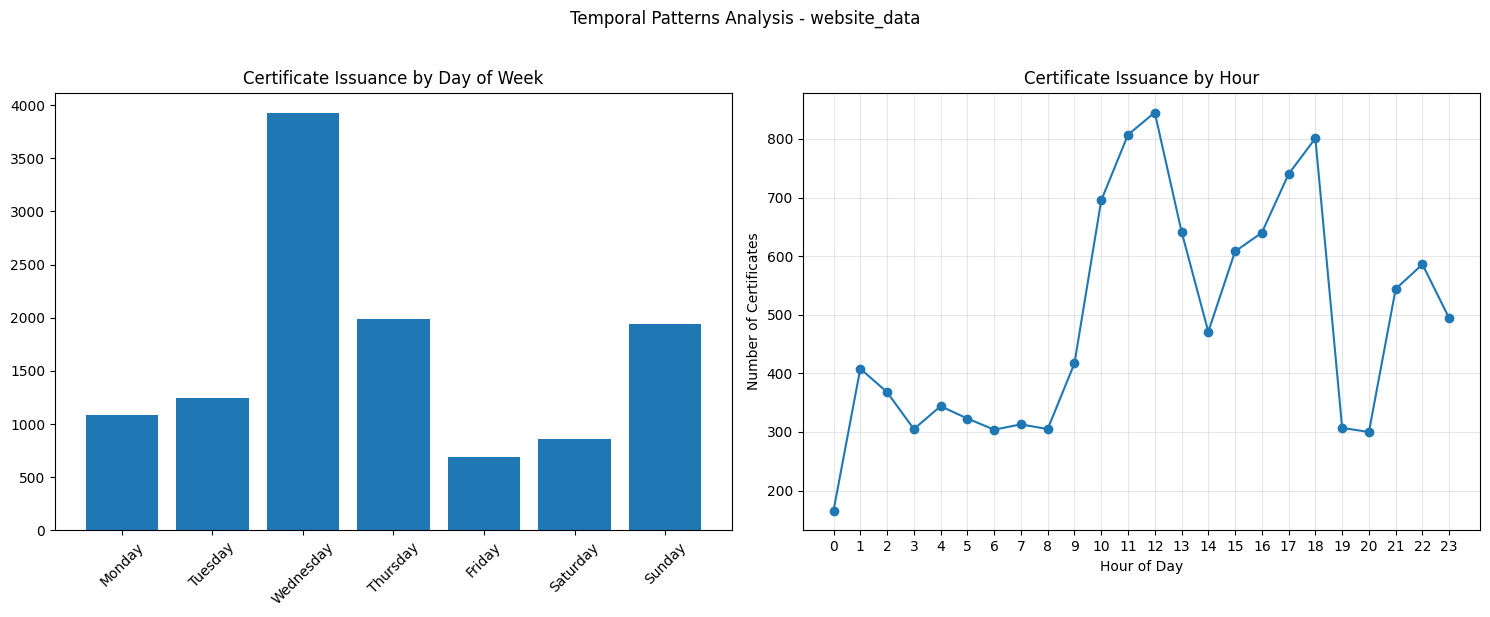


Results saved to /home/asomura/waseda/nextstep/RAPIDS/reports/temporal_analysis

Analyzing normal_sites...
Extracted 9591 records

Validity Period Analysis:
Mean validity: 47.24 days
Short-term certificates: 76.74%

Initial Data Analysis:
Total records: 9591
Unique domains: 9591
Domains with multiple certificates: 0

Renewal Pattern Analysis:
Mean renewal interval: 0.00 days

Temporal Pattern Analysis:
Weekend ratio: 24.29%
Business hours ratio: 28.30%


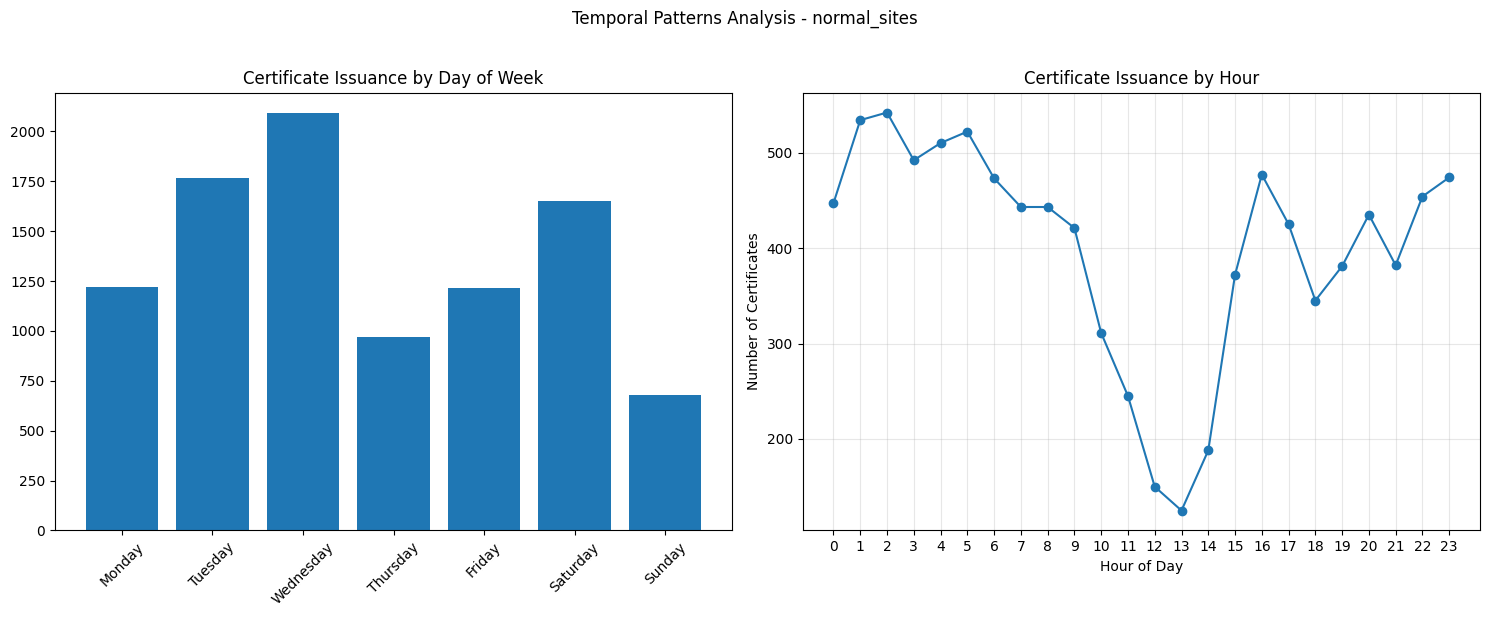


Results saved to /home/asomura/waseda/nextstep/RAPIDS/reports/temporal_analysis


In [12]:
def main():
    """Main execution function"""
    # Set up base output directory
    base_dir = Path('/home/asomura/waseda/nextstep/RAPIDS')
    output_dir = base_dir / 'reports' / 'temporal_analysis'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    databases = ['website_data', 'normal_sites']
    
    for db_name in databases:
        print(f"\nAnalyzing {db_name}...")
        
        try:
            # Extract data
            df = extract_certificate_data(db_name)
            print(f"Extracted {len(df)} records")
            
            # Analyze validity periods
            validity_results = analyze_validity_periods(df)
            print("\nValidity Period Analysis:")
            print(f"Mean validity: {validity_results['statistics']['mean']:.2f} days")
            print(f"Short-term certificates: {validity_results['categories']['short_term']:.2%}")
            
            # Analyze renewal patterns
            renewal_results = analyze_renewal_patterns(df)
            print("\nRenewal Pattern Analysis:")
            print(f"Mean renewal interval: {renewal_results['statistics']['mean_interval']:.2f} days")
            
            # Analyze temporal patterns
            temporal_results = analyze_temporal_patterns(df)
            print("\nTemporal Pattern Analysis:")
            print(f"Weekend ratio: {temporal_results['patterns']['weekend_ratio']:.2%}")
            print(f"Business hours ratio: {temporal_results['patterns']['business_hours_ratio']:.2%}")
            
            # Create and display plots
            plot_temporal_patterns(temporal_results, db_name, output_dir)
            
            print(f"\nResults saved to {output_dir}")
            
        except Exception as e:
            print(f"Error analyzing {db_name}: {str(e)}")
            logging.error(f"Error analyzing {db_name}: {str(e)}")

if __name__ == "__main__":
    main()